This notebook applies classification algorithms to 

In [101]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [102]:
hard_drive_df = pd.read_csv('hard_drive_df_for_binary_classification_60.csv')

In [103]:
hard_drive_df.columns

Index(['date', 'fail_next_60_days', 'failure', 'model', 'serial_number',
       'smart_184_from_mean_10', 'smart_184_from_mean_20',
       'smart_184_from_mean_30', 'smart_184_raw', 'smart_184_rw10_mean',
       ...
       'smart_5_from_mean_30', 'smart_5_raw', 'smart_5_rw10_mean',
       'smart_5_rw10_std', 'smart_5_rw20_mean', 'smart_5_rw20_std',
       'smart_5_rw30_mean', 'smart_5_rw30_std', 'smart_5_vel', 'smart_9_raw'],
      dtype='object', length=116)

In [104]:
print(hard_drive_df.columns[:50])
print(hard_drive_df.columns[50:])

Index(['date', 'fail_next_60_days', 'failure', 'model', 'serial_number',
       'smart_184_from_mean_10', 'smart_184_from_mean_20',
       'smart_184_from_mean_30', 'smart_184_raw', 'smart_184_rw10_mean',
       'smart_184_rw10_std', 'smart_184_rw20_mean', 'smart_184_rw20_std',
       'smart_184_rw30_mean', 'smart_184_rw30_std', 'smart_184_vel',
       'smart_187_from_mean_10', 'smart_187_from_mean_20',
       'smart_187_from_mean_30', 'smart_187_raw', 'smart_187_rw10_mean',
       'smart_187_rw10_std', 'smart_187_rw20_mean', 'smart_187_rw20_std',
       'smart_187_rw30_mean', 'smart_187_rw30_std', 'smart_187_vel',
       'smart_188_from_mean_10', 'smart_188_from_mean_20',
       'smart_188_from_mean_30', 'smart_188_raw', 'smart_188_rw10_mean',
       'smart_188_rw10_std', 'smart_188_rw20_mean', 'smart_188_rw20_std',
       'smart_188_rw30_mean', 'smart_188_rw30_std', 'smart_188_vel',
       'smart_193_from_mean_10', 'smart_193_from_mean_20',
       'smart_193_from_mean_30', 'smart_193

In [105]:
print(len(hard_drive_df.columns))
print(len(set(hard_drive_df.columns)))

116
116


We will consider different combination of features. 

Start with the ones that Backblaze considers critical:
* 187,188,197,198,5
* use the mean, std, diff, and diff from mean features with the above smart variables
* see if adding 241,242,194,193,184 imporves the results

In [5]:
'''hard_drive_df_10 = hard_drive_df[['date', 'fail_next_30_days', 'failure', 'model',
       'serial_number','smart_187_from_mean_10', 'smart_187_raw', 'smart_187_rw10_mean',
       'smart_187_rw10_std', 'smart_187_vel',
       'smart_188_from_mean_10', 'smart_188_raw', 'smart_188_rw10_mean',
       'smart_188_rw10_std', 'smart_188_vel','smart_197_from_mean_10', 'smart_197_raw', 'smart_197_rw10_mean',
       'smart_197_rw10_std', 'smart_197_vel',
       'smart_198_from_mean_10', 'smart_198_raw', 'smart_198_rw10_mean',
       'smart_198_rw10_std', 'smart_198_vel','smart_5_from_mean_10',
       'smart_5_raw', 'smart_5_rw10_mean', 'smart_5_rw10_std','smart_5_vel']]'''

"hard_drive_df_10 = hard_drive_df[['date', 'fail_next_30_days', 'failure', 'model',\n       'serial_number','smart_187_from_mean_10', 'smart_187_raw', 'smart_187_rw10_mean',\n       'smart_187_rw10_std', 'smart_187_vel',\n       'smart_188_from_mean_10', 'smart_188_raw', 'smart_188_rw10_mean',\n       'smart_188_rw10_std', 'smart_188_vel','smart_197_from_mean_10', 'smart_197_raw', 'smart_197_rw10_mean',\n       'smart_197_rw10_std', 'smart_197_vel',\n       'smart_198_from_mean_10', 'smart_198_raw', 'smart_198_rw10_mean',\n       'smart_198_rw10_std', 'smart_198_vel','smart_5_from_mean_10',\n       'smart_5_raw', 'smart_5_rw10_mean', 'smart_5_rw10_std','smart_5_vel']]"

In [106]:
hard_drive_df_10 = hard_drive_df[list(set(hard_drive_df.columns))]

In [107]:
len(hard_drive_df_10.columns)

116

In [108]:
len(set(hard_drive_df.columns))

116

The hard drive data contains some nan values created in the process of creating new features (some will have 10 nans per hard drive info, some 20, some 30, etc). Depending on the features used we will remove the coresponding rows containing nans

In [109]:
hard_drive_df = hard_drive_df.dropna(how='any').reset_index()   

In [110]:
hard_drive_df = hard_drive_df.drop('index', axis=1)

In [111]:
hard_drive_df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598582 entries, 0 to 3598581
Columns: 116 entries, date to smart_9_raw
dtypes: float64(111), int64(2), object(3)
memory usage: 3.1+ GB


In [112]:
len(hard_drive_df[hard_drive_df.failure == 1].serial_number.unique())

246

In [113]:
len(hard_drive_df.serial_number.unique())

19960

We have highly unbalanced dataset, out of 22898 hard drives only 277 have failed (1.2 %)

In [114]:
print(len(set(hard_drive_df.columns)))
print(len(hard_drive_df.columns))

116
116


Steps to take:
* split the set into test and train
* cross validation
* train into train and val
* normalize (some algorithms do not need normalization)
* train 
* check the test results

When splitting the data into train,test and val we need to make sure that a serial number does appear in more than one set so we don't have data leakage issues

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,precision_recall_curve, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import RandomOverSampler

In [116]:
# 25 % test and 75 % train
failed_hard_drive_list = hard_drive_df[hard_drive_df.failure == 1].serial_number.unique()

In [117]:
working_hard_drive_list = hard_drive_df[~hard_drive_df.serial_number.isin(failed_hard_drive_list)].serial_number.unique()

In [118]:
# randomly pick 25% from each list --> hold out test set
# the rest of 75% from each list --> train set 


In [119]:
# split the failed and working hard drive into 25% and 75% to use for train and test set
train_hd_failed, test_hd_failed = train_test_split(failed_hard_drive_list,test_size=0.25, random_state=42)
train_hd_working, test_hd_working = train_test_split(working_hard_drive_list,test_size=0.25, random_state=42)

In [120]:
# get the serial numbers for test and train set
test_serial_num = np.concatenate((test_hd_working,test_hd_failed), axis = 0)
train_serial_number =  np.concatenate((train_hd_working,train_hd_failed), axis = 0)

In [121]:
# get the train and test dataframes
train_df = hard_drive_df[hard_drive_df.serial_number.isin(train_serial_number)]
test_df = hard_drive_df[hard_drive_df.serial_number.isin(test_serial_num)]

In [122]:
train_df.columns

Index(['date', 'fail_next_60_days', 'failure', 'model', 'serial_number',
       'smart_184_from_mean_10', 'smart_184_from_mean_20',
       'smart_184_from_mean_30', 'smart_184_raw', 'smart_184_rw10_mean',
       ...
       'smart_5_from_mean_30', 'smart_5_raw', 'smart_5_rw10_mean',
       'smart_5_rw10_std', 'smart_5_rw20_mean', 'smart_5_rw20_std',
       'smart_5_rw30_mean', 'smart_5_rw30_std', 'smart_5_vel', 'smart_9_raw'],
      dtype='object', length=116)

In [123]:
print(len(set(train_df.columns)))
print(len(train_df.columns))

116
116


Once we have the train set, we use crossvalidation. 

We will split the dataset into 5 parts

In [124]:
import random

# randomly shuffle train failed and working sets
random.shuffle(train_hd_failed)
random.shuffle(train_hd_working)

In [125]:
# split the failed and working train into 5 groups (5 fold)
kfold_failed = np.array_split(train_hd_failed,3)
kfold_working = np.array_split(train_hd_working,3)


In [126]:
# put the failed ones and the working ones together
kfold_5 = []
for i,j in zip(kfold_failed,kfold_working):
    kfold_5.append(np.concatenate((i,j),axis = 0))


In [128]:
# features and target variables to use in training
#mask = ['fail_next_60_days','smart_187_raw','smart_5_raw']
mask = ['fail_next_60_days','smart_9_raw','smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']

#mask = ['fail_next_60_days','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw','smart_5_raw']
#mask = ['fail_next_30_days','smart_187_from_mean_10', 'smart_187_rw10_mean',
#       'smart_187_rw10_std', 'smart_187_vel', 'smart_188_from_mean_10',
#       'smart_188_rw10_mean', 'smart_188_rw10_std',
#       'smart_188_vel', 'smart_197_from_mean_10',
#       'smart_197_rw10_mean', 'smart_197_rw10_std', 'smart_197_vel',
#       'smart_198_from_mean_10', 'smart_198_rw10_mean',
#       'smart_198_rw10_std', 'smart_198_vel', 'smart_5_from_mean_10',
#        'smart_5_rw10_mean', 'smart_5_rw10_std', 'smart_5_vel']

In [25]:
mask = ['fail_next_30_days','smart_187_from_mean_10', 'smart_187_rw10_mean',
       'smart_187_rw10_std', 'smart_187_vel', 'smart_188_from_mean_10',
       'smart_188_rw10_mean', 'smart_188_rw10_std',
       'smart_188_vel', 'smart_197_from_mean_10',
       'smart_197_rw10_mean', 'smart_197_rw10_std', 'smart_197_vel',
       'smart_198_from_mean_10', 'smart_198_rw10_mean',
       'smart_198_rw10_std', 'smart_198_vel', 'smart_5_from_mean_10',
        'smart_5_rw10_mean', 'smart_5_rw10_std', 'smart_5_vel']

In [26]:
mask = ['fail_next_60_days','smart_187_from_mean_10', 'smart_187_rw10_mean',
       'smart_187_rw10_std', 'smart_187_vel', 'smart_188_from_mean_10',
       'smart_188_rw10_mean', 'smart_188_rw10_std',
       'smart_188_vel',
       'smart_198_from_mean_10', 'smart_198_rw10_mean',
       'smart_198_rw10_std', 'smart_198_vel', 'smart_5_from_mean_10',
        'smart_5_rw10_mean', 'smart_5_rw10_std', 'smart_5_vel']

In [27]:
mask = ['fail_next_60_days','smart_187_from_mean_20', 'smart_187_rw20_mean',
       'smart_187_rw20_std', 'smart_187_vel', 'smart_188_from_mean_20',
       'smart_188_rw20_mean', 'smart_188_rw20_std',
       'smart_188_vel',
       'smart_198_from_mean_20', 'smart_198_rw20_mean',
       'smart_198_rw20_std', 'smart_198_vel', 'smart_5_from_mean_20',
        'smart_5_rw20_mean', 'smart_5_rw20_std', 'smart_5_vel']

In [132]:
mask = ['fail_next_60_days','smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw',
        'smart_187_from_mean_30', 'smart_187_rw30_mean','smart_9_raw',
       'smart_187_rw30_std', 'smart_187_vel', 'smart_188_from_mean_30',
       'smart_188_rw30_mean', 'smart_188_rw30_std',
       'smart_188_vel',
       'smart_198_from_mean_30', 'smart_198_rw30_mean',
       'smart_198_rw30_std', 'smart_198_vel', 'smart_5_from_mean_30',
        'smart_5_rw30_mean', 'smart_5_rw30_std', 'smart_5_vel']


In [29]:
mask = ['fail_next_60_days','smart_5_raw','smart_187_raw','smart_188_raw','smart_198_raw',
        'smart_187_from_mean_30', 'smart_188_from_mean_30',
       'smart_198_from_mean_30', 'smart_5_from_mean_30','smart_187_rw30_std',
       'smart_188_rw30_std','smart_198_rw30_std','smart_5_rw30_std']

#### random forest

In [39]:
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []

threshold = .83
n_est = 200
m_depth = 5
for m_depth in np.arange(1,202,50):
    rf_val_f1_score_list = []
    rf_val_accuracy_list = []
    rf_val_recall_list = []
    rf_val_precision_list = []

    rf_tr_f1_score_list = []
    rf_tr_accuracy_list = []
    rf_tr_recall_list = []
    rf_tr_precision_list = []
    for val_group_index in range(len(kfold_5)):
        # get serial numbers in val and train sets
        train_s_nums = kfold_5[:val_group_index]+kfold_5[val_group_index+1:]
        val_s_nums = kfold_5[val_group_index]

        # get the data for train and val sets
        train_data = train_df[train_df.serial_number.isin(np.concatenate(train_s_nums))][mask]
        val_data = train_df[train_df.serial_number.isin(val_s_nums)][mask]
        
        # shuffle randomly the train and the val sets
        train_data.sample(frac=1)
        val_data.sample(frac=1)
        
        
        # get X_tr,y_tr,X_val, y_val
        X_tr, y_tr = train_data[mask].drop('fail_next_60_days',axis=1), train_data['fail_next_60_days'] 
        X_vl, y_vl = val_data[mask].drop('fail_next_60_days',axis=1), val_data['fail_next_60_days'] 

        # scale the data
        #scaler = StandardScaler()
        #X_tr_scaled = scaler.fit_transform(X_tr)
        #X_vl_scaled = scaler.transform(X_vl)

        # over sample 
        #ros = RandomOverSampler(random_state=1)
        #X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

        # under sample
        ind = y_tr[y_tr==0].sample(len(y_tr[y_tr==1])).index
        y_resampled = pd.concat([y_tr[ind],y_tr[y_tr==1]])
        X_resampled = X_tr.loc[y_resampled.index]
        #y_resampled = y_tr
        
        
        # model
        model = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
        model.fit(X_resampled,y_resampled)

        train_predicted = (model.predict_proba(X_resampled)[:, 1] >= threshold)

        val_predicted = (model.predict_proba(X_vl)[:, 1] >= threshold)

        rf_tr_accuracy_list.append(accuracy_score(y_resampled, train_predicted))
        rf_tr_recall_list.append(recall_score(y_resampled, train_predicted))
        rf_tr_precision_list.append(precision_score(y_resampled, train_predicted))
        rf_tr_f1_score_list.append(f1_score(y_resampled, train_predicted))

        rf_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
        rf_val_recall_list.append(recall_score(y_vl, val_predicted))
        rf_val_precision_list.append(precision_score(y_vl, val_predicted))
        rf_val_f1_score_list.append(f1_score(y_vl, val_predicted))

    rf_tr_mean_accuracy = sum(rf_tr_accuracy_list)/len(rf_tr_accuracy_list)
    rf_tr_mean_precision = sum(rf_tr_precision_list)/len(rf_tr_precision_list)
    rf_tr_mean_recall = sum(rf_tr_recall_list)/len(rf_tr_recall_list)
    rf_tr_mean_f1 = sum(rf_tr_f1_score_list)/len(rf_tr_f1_score_list)

    rf_vl_mean_accuracy = sum(rf_val_accuracy_list)/len(rf_val_accuracy_list)
    rf_vl_mean_precision = sum(rf_val_precision_list)/len(rf_val_precision_list)
    rf_vl_mean_recall = sum(rf_val_recall_list)/len(rf_val_recall_list)
    rf_vl_mean_f1 = sum(rf_val_f1_score_list)/len(rf_val_f1_score_list)
    print('Train               Validation')
    print('accuracy')
    print(rf_tr_mean_accuracy,rf_vl_mean_accuracy)
    print('precision')
    print(rf_tr_mean_precision,rf_vl_mean_precision)
    print('recall')
    print(rf_tr_mean_recall,rf_vl_mean_recall)
    print('f1 score')
    print(rf_tr_mean_f1,rf_vl_mean_f1)    


Train               Validation
accuracy
0.6289608677389723 0.99021373210097
precision
0.9753095082043384 0.118782445623885
recall
0.26461513525791064 0.264696788861777
f1 score
0.4161788441826932 0.1638892083774152
Train               Validation
accuracy
0.7130732099118918 0.9881575845440005
precision
0.9870435001637109 0.1112805911910046
recall
0.43184918657536714 0.31079411228046827
f1 score
0.6006442668549866 0.16288747002702006
Train               Validation
accuracy
0.7147321342251587 0.9880527202330804
precision
0.987789080756881 0.1037831332371314
recall
0.43483439630596427 0.2938024240121631
f1 score
0.6037530188748214 0.1527145992781781
Train               Validation
accuracy
0.7152027088846403 0.9877948253274288
precision
0.9858420809414529 0.10383706127683857
recall
0.4366746048166028 0.29879511525924185
f1 score
0.605122832836603 0.15354960734804637
Train               Validation
accuracy
0.7134856471022987 0.9886683824167007
precision
0.9877732048237315 0.11482771132352214

In [35]:
mask

['fail_next_60_days',
 'smart_5_raw',
 'smart_187_raw',
 'smart_188_raw',
 'smart_197_raw',
 'smart_198_raw',
 'smart_187_from_mean_30',
 'smart_187_rw30_mean',
 'smart_187_rw30_std',
 'smart_187_vel',
 'smart_188_from_mean_30',
 'smart_188_rw30_mean',
 'smart_188_rw30_std',
 'smart_188_vel',
 'smart_198_from_mean_30',
 'smart_198_rw30_mean',
 'smart_198_rw30_std',
 'smart_198_vel',
 'smart_5_from_mean_30',
 'smart_5_rw30_mean',
 'smart_5_rw30_std',
 'smart_5_vel']

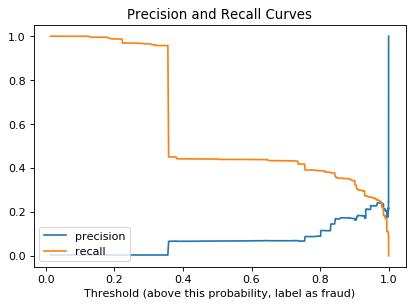

In [34]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [115]:
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []

threshold = .94
n_est = 200
m_depth = 5
#for n_est in np.arange(1,202,50):
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []
for val_group_index in range(len(kfold_5)):
    # get serial numbers in val and train sets
    train_s_nums = kfold_5[:val_group_index]+kfold_5[val_group_index+1:]
    val_s_nums = kfold_5[val_group_index]

    # get the data for train and val sets
    train_data = train_df[train_df.serial_number.isin(np.concatenate(train_s_nums))][mask]
    val_data = train_df[train_df.serial_number.isin(val_s_nums)][mask]

    # get X_tr,y_tr,X_val, y_val
    X_tr, y_tr = train_data[mask].drop('fail_next_60_days',axis=1), train_data['fail_next_60_days'] 
    X_vl, y_vl = val_data[mask].drop('fail_next_60_days',axis=1), val_data['fail_next_60_days'] 

    # scale the data
    #scaler = StandardScaler()
    #X_tr_scaled = scaler.fit_transform(X_tr)
    #X_vl_scaled = scaler.transform(X_vl)

    # over sample 
    #ros = RandomOverSampler(random_state=1)
    #X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

    # under sample
    ind = y_tr[y_tr==0].sample(len(y_tr[y_tr==1])).index
    y_resampled = pd.concat([y_tr[ind],y_tr[y_tr==1]])
    X_resampled = X_tr.loc[y_resampled.index]
    #y_resampled = y_tr
    #X_resampled = X_tr
    # model
    model = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
    model.fit(X_resampled,y_resampled)

    train_predicted = (model.predict_proba(X_resampled)[:, 1] >= threshold)

    val_predicted = (model.predict_proba(X_vl)[:, 1] >= threshold)

    rf_tr_accuracy_list.append(accuracy_score(y_resampled, train_predicted))
    rf_tr_recall_list.append(recall_score(y_resampled, train_predicted))
    rf_tr_precision_list.append(precision_score(y_resampled, train_predicted))
    rf_tr_f1_score_list.append(f1_score(y_resampled, train_predicted))

    rf_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
    rf_val_recall_list.append(recall_score(y_vl, val_predicted))
    rf_val_precision_list.append(precision_score(y_vl, val_predicted))
    rf_val_f1_score_list.append(f1_score(y_vl, val_predicted))

rf_tr_mean_accuracy = sum(rf_tr_accuracy_list)/len(rf_tr_accuracy_list)
rf_tr_mean_precision = sum(rf_tr_precision_list)/len(rf_tr_precision_list)
rf_tr_mean_recall = sum(rf_tr_recall_list)/len(rf_tr_recall_list)
rf_tr_mean_f1 = sum(rf_tr_f1_score_list)/len(rf_tr_f1_score_list)

rf_vl_mean_accuracy = sum(rf_val_accuracy_list)/len(rf_val_accuracy_list)
rf_vl_mean_precision = sum(rf_val_precision_list)/len(rf_val_precision_list)
rf_vl_mean_recall = sum(rf_val_recall_list)/len(rf_val_recall_list)
rf_vl_mean_f1 = sum(rf_val_f1_score_list)/len(rf_val_f1_score_list)
print('Train               Validation')
print('accuracy')
print(rf_tr_mean_accuracy,rf_vl_mean_accuracy)
print('precision')
print(rf_tr_mean_precision,rf_vl_mean_precision)
print('recall')
print(rf_tr_mean_recall,rf_vl_mean_recall)
print('f1 score')
print(rf_tr_mean_f1,rf_vl_mean_f1)    


Train               Validation
accuracy
0.6511737010322332 0.9943167174949584
precision
0.9969576719576719 0.22267851730080526
recall
0.30331151447877697 0.22917942352824353
f1 score
0.4641632634011998 0.22344826530281306


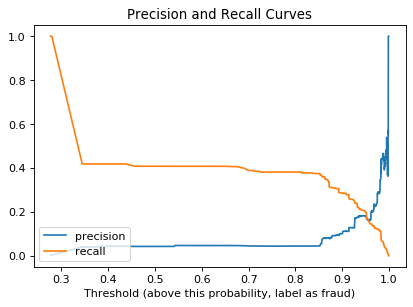

In [113]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [182]:
mask = ['fail_next_60_days','smart_9_raw','smart_5_raw','smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']


In [183]:
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []

threshold = .07

n_est = 200
m_depth = 5
#for n_est in np.arange(1,202,50):
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []
for val_group_index in range(len(kfold_5)):
    # get serial numbers in val and train sets
    train_s_nums = kfold_5[:val_group_index]+kfold_5[val_group_index+1:]
    val_s_nums = kfold_5[val_group_index]

    # get the data for train and val sets
    train_data = train_df[train_df.serial_number.isin(np.concatenate(train_s_nums))][mask]
    val_data = train_df[train_df.serial_number.isin(val_s_nums)][mask]

    # get X_tr,y_tr,X_val, y_val
    X_tr, y_tr = train_data[mask].drop('fail_next_60_days',axis=1), train_data['fail_next_60_days'] 
    X_vl, y_vl = val_data[mask].drop('fail_next_60_days',axis=1), val_data['fail_next_60_days'] 

    # scale the data
    #scaler = StandardScaler()
    #X_tr_scaled = scaler.fit_transform(X_tr)
    #X_vl_scaled = scaler.transform(X_vl)

    # over sample 
    #ros = RandomOverSampler(random_state=1)
    #X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

    # under sample
    #ind = y_tr[y_tr==0].sample(len(y_tr[y_tr==1])).index
    #y_resampled = pd.concat([y_tr[ind],y_tr[y_tr==1]])
    #X_resampled = X_tr.loc[y_resampled.index]
    y_resampled = y_tr
    X_resampled = X_tr
    #X_vl = X_vl_scaled
    # model
    model = XGBClassifier()
    model.fit(X_resampled,y_resampled)

    train_predicted = (model.predict_proba(X_resampled)[:, 1] >= threshold)

    val_predicted = (model.predict_proba(X_vl)[:, 1] >= threshold)

    rf_tr_accuracy_list.append(accuracy_score(y_resampled, train_predicted))
    rf_tr_recall_list.append(recall_score(y_resampled, train_predicted))
    rf_tr_precision_list.append(precision_score(y_resampled, train_predicted))
    rf_tr_f1_score_list.append(f1_score(y_resampled, train_predicted))

    rf_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
    rf_val_recall_list.append(recall_score(y_vl, val_predicted))
    rf_val_precision_list.append(precision_score(y_vl, val_predicted))
    rf_val_f1_score_list.append(f1_score(y_vl, val_predicted))

rf_tr_mean_accuracy = sum(rf_tr_accuracy_list)/len(rf_tr_accuracy_list)
rf_tr_mean_precision = sum(rf_tr_precision_list)/len(rf_tr_precision_list)
rf_tr_mean_recall = sum(rf_tr_recall_list)/len(rf_tr_recall_list)
rf_tr_mean_f1 = sum(rf_tr_f1_score_list)/len(rf_tr_f1_score_list)

rf_vl_mean_accuracy = sum(rf_val_accuracy_list)/len(rf_val_accuracy_list)
rf_vl_mean_precision = sum(rf_val_precision_list)/len(rf_val_precision_list)
rf_vl_mean_recall = sum(rf_val_recall_list)/len(rf_val_recall_list)
rf_vl_mean_f1 = sum(rf_val_f1_score_list)/len(rf_val_f1_score_list)
print('Train               Validation')
print('accuracy')
print(rf_tr_mean_accuracy,rf_vl_mean_accuracy)
print('precision')
print(rf_tr_mean_precision,rf_vl_mean_precision)
print('recall')
print(rf_tr_mean_recall,rf_vl_mean_recall)
print('f1 score')
print(rf_tr_mean_f1,rf_vl_mean_f1)    


Train               Validation
accuracy
0.9941172230071093 0.9922988358584349
precision
0.26039631147341696 0.16190300729972482
recall
0.3317999606980742 0.25701708501825654
f1 score
0.2909903596558711 0.19472199493668318


In [185]:
X_ts, y_ts = test_df[mask].drop('fail_next_60_days',axis=1), test_df['fail_next_60_days'] 
ts_predicted = (model.predict_proba(X_ts)[:, 1] >= threshold)


print(recall_score(y_ts, ts_predicted))
print(precision_score(y_ts, ts_predicted))
print(f1_score(y_ts, ts_predicted))

0.37315724815724816
0.1643002028397566
0.22814759177542018


In [ ]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [152]:
rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []

threshold = .07

rf_val_f1_score_list = []
rf_val_accuracy_list = []
rf_val_recall_list = []
rf_val_precision_list = []

rf_tr_f1_score_list = []
rf_tr_accuracy_list = []
rf_tr_recall_list = []
rf_tr_precision_list = []
for val_group_index in range(len(kfold_5)):
    # get serial numbers in val and train sets
    train_s_nums = kfold_5[:val_group_index]+kfold_5[val_group_index+1:]
    val_s_nums = kfold_5[val_group_index]

    # get the data for train and val sets
    train_data = train_df[train_df.serial_number.isin(np.concatenate(train_s_nums))][mask]
    val_data = train_df[train_df.serial_number.isin(val_s_nums)][mask]

    # get X_tr,y_tr,X_val, y_val
    X_tr, y_tr = train_data[mask].drop('fail_next_60_days',axis=1), train_data['fail_next_60_days'] 
    X_vl, y_vl = val_data[mask].drop('fail_next_60_days',axis=1), val_data['fail_next_60_days'] 

    # scale the data
    #scaler = StandardScaler()
    #X_tr_scaled = scaler.fit_transform(X_tr)
    #X_vl_scaled = scaler.transform(X_vl)

    # over sample 
    #ros = RandomOverSampler(random_state=1)
    #X_resampled, y_resampled = ros.fit_sample(X_tr, y_tr)

    # under sample
    #ind = y_tr[y_tr==0].sample(len(y_tr[y_tr==1])).index
    #y_resampled = pd.concat([y_tr[ind],y_tr[y_tr==1]])
    #X_resampled = X_tr.loc[y_resampled.index]
    y_resampled = y_tr
    X_resampled = X_tr
    #X_vl = X_vl_scaled
    # model
    model = XGBClassifier()
    model.fit(X_resampled,y_resampled)

    train_predicted = (model.predict_proba(X_resampled)[:, 1] >= threshold)

    val_predicted = (model.predict_proba(X_vl)[:, 1] >= threshold)

    rf_tr_accuracy_list.append(accuracy_score(y_resampled, train_predicted))
    rf_tr_recall_list.append(recall_score(y_resampled, train_predicted))
    rf_tr_precision_list.append(precision_score(y_resampled, train_predicted))
    rf_tr_f1_score_list.append(f1_score(y_resampled, train_predicted))

    rf_val_accuracy_list.append(accuracy_score(y_vl, val_predicted))
    rf_val_recall_list.append(recall_score(y_vl, val_predicted))
    rf_val_precision_list.append(precision_score(y_vl, val_predicted))
    rf_val_f1_score_list.append(f1_score(y_vl, val_predicted))

rf_tr_mean_accuracy = sum(rf_tr_accuracy_list)/len(rf_tr_accuracy_list)
rf_tr_mean_precision = sum(rf_tr_precision_list)/len(rf_tr_precision_list)
rf_tr_mean_recall = sum(rf_tr_recall_list)/len(rf_tr_recall_list)
rf_tr_mean_f1 = sum(rf_tr_f1_score_list)/len(rf_tr_f1_score_list)

rf_vl_mean_accuracy = sum(rf_val_accuracy_list)/len(rf_val_accuracy_list)
rf_vl_mean_precision = sum(rf_val_precision_list)/len(rf_val_precision_list)
rf_vl_mean_recall = sum(rf_val_recall_list)/len(rf_val_recall_list)
rf_vl_mean_f1 = sum(rf_val_f1_score_list)/len(rf_val_f1_score_list)
print('Train               Validation')
print('accuracy')
print(rf_tr_mean_accuracy,rf_vl_mean_accuracy)
print('precision')
print(rf_tr_mean_precision,rf_vl_mean_precision)
print('recall')
print(rf_tr_mean_recall,rf_vl_mean_recall)
print('f1 score')
print(rf_tr_mean_f1,rf_vl_mean_f1)    


Train               Validation
accuracy
0.9951831167515254 0.9937372162793218
precision
0.3475076177653558 0.22494598534122337
recall
0.37213149458600653 0.2960591030072175
f1 score
0.3591029529711031 0.25469131297268394


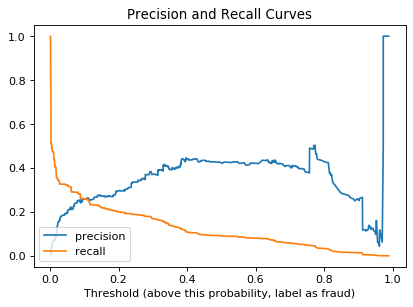

In [149]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_vl,model.predict_proba(X_vl)[:, 1] )


plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [154]:
X_ts, y_ts = test_df[mask].drop('fail_next_60_days',axis=1), test_df['fail_next_60_days'] 
ts_predicted = (model.predict_proba(X_ts)[:, 1] >= threshold)


print(recall_score(y_ts, ts_predicted))
print(precision_score(y_ts, ts_predicted))
print(f1_score(y_ts, ts_predicted))

In [167]:
ts_predicted = pd.DataFrame(ts_predicted, index = y_ts.index)

In [158]:
y_ts

0          0
1          0
2          0
3          0
4          0
          ..
3598568    1
3598569    1
3598570    1
3598571    1
3598572    1
Name: fail_next_60_days, Length: 900433, dtype: int64

In [175]:
df = pd.concat([test_df.serial_number,X_ts,y_ts,ts_predicted],axis=1)

In [176]:
df

,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,...,smart_198_from_mean_30,smart_198_rw30_mean,smart_198_rw30_std,smart_198_vel,smart_5_from_mean_30,smart_5_rw30_mean,smart_5_rw30_std,smart_5_vel,fail_next_60_days,0
0,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15266.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
1,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15290.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
2,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15314.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
3,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15337.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
4,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15361.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598568,Z305NZY4,0.0,4.0,0.0,0.0,0.0,3.566667,0.433333,26569.0,0.971431,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1,True
3598569,Z305NZY4,8.0,8.0,0.0,0.0,0.0,7.300000,0.700000,26593.0,1.684616,...,0.000000,0.000000,0.000000,0.0,7.733333,0.266667,1.460593,8.0,1,True
3598570,Z305NZY4,8.0,9.0,0.0,8.0,8.0,8.000000,1.000000,26616.0,2.259081,...,7.733333,0.266667,1.460593,8.0,7.466667,0.533333,2.029665,0.0,1,True
3598571,Z305NZY4,8.0,9.0,0.0,8.0,8.0,7.700000,1.300000,26640.0,2.680067,...,7.466667,0.533333,2.029665,0.0,7.200000,0.800000,2.441029,0.0,1,True


In [177]:
df[(df.fail_next_60_days == 1) & (df[0] == True)].serial_number.unique()

array(['S300YSEP', 'S300Z5JP', 'S300ZRP2', 'S30108L3', 'S301168X',
       'S301GM66', 'S301GQQV', 'S301K0GV', 'S301NXNV', 'Z30251BE',
       'Z302AB82', 'Z302S7HN', 'Z302SLDV', 'Z302SYHF', 'Z302SZ70',
       'Z302SZLQ', 'Z302T6JA', 'Z302T6JR', 'Z302T7HK', 'Z30417KE',
       'Z304JD9J', 'Z304JDDH', 'Z304JDL5', 'Z304JNLW', 'Z304JVYJ',
       'Z304JW84', 'Z304KCFR', 'Z304RKYC', 'Z304TK95', 'Z304V9Z7',
       'Z305A432', 'Z305BE77', 'Z305D21E', 'Z305DF66', 'Z305DHXM',
       'Z305DVWM', 'Z305KVHS', 'Z305NZY4'], dtype=object)

In [178]:
# False negative
df[(df.fail_next_60_days == 1) & (df[0] == False)].serial_number.unique()

array(['S300XCAB', 'S300YSEP', 'S300Z43B', 'S300Z5JP', 'S300Z5S4',
       'S300Z6M5', 'S300Z731', 'S30108L3', 'S301GM66', 'S301GNMZ',
       'S301GQQV', 'S301K0GV', 'S301KX89', 'S301NKJR', 'S301NL7L',
       'Z30251BE', 'Z302701J', 'Z3029AR3', 'Z302SLDV', 'Z302SYHF',
       'Z302SZ70', 'Z302T7HK', 'Z302T7P7', 'Z30417KE', 'Z304HV83',
       'Z304JD9J', 'Z304JDL3', 'Z304JDL5', 'Z304JNLW', 'Z304JW84',
       'Z304KCFR', 'Z304KCYE', 'Z304KD5E', 'Z304KR0Q', 'Z304RKYC',
       'Z304T5E0', 'Z304V9Z7', 'Z305A432', 'Z305B5X2', 'Z305BE77',
       'Z305C0ZN', 'Z305D21E', 'Z305D2NT', 'Z305DHXM', 'Z305DVWM',
       'Z305DXS7', 'Z305GXC1', 'Z305KVHS', 'Z305L695', 'Z305NZY4'],
      dtype=object)

In [179]:
# False positive
df[(df.fail_next_60_days == 0) & (df[0] == True)].serial_number.unique()

array(['S300VLDW', 'S300XAAX', 'S300YQ5Z', 'S300Z41Z', 'S300Z5YQ',
       'S301096D', 'S30115KF', 'S30117KN', 'S301B7HK', 'S301GS26',
       'S301K6TW', 'S301MHZB', 'S301PQ2V', 'S301PSL2', 'W300R9SJ',
       'Z30250YQ', 'Z3029ZB8', 'Z302A1MK', 'Z302AK8B', 'Z302B1NQ',
       'Z302BV7C', 'Z302KJSG', 'Z302SWQZ', 'Z302SY6Y', 'Z302SYFG',
       'Z302SZ1N', 'Z302T5FP', 'Z302T8YL', 'Z303F1DY', 'Z303RRM9',
       'Z3040EBR', 'Z304H8A8', 'Z304HSEV', 'Z304JAGC', 'Z304JJ7R',
       'Z304JLMF', 'Z304JS04', 'Z304JSFB', 'Z304JWJV', 'Z304KCP7',
       'Z304KCSN', 'Z304KEWX', 'Z304L8XR', 'Z304L9AJ', 'Z304LAHV',
       'Z304QHY7', 'Z304TE6V', 'Z304WGN0', 'Z304XPJH', 'Z304Y4NZ',
       'Z304ZXKS', 'Z304ZZEZ', 'Z3050QDR', 'Z3055EKF', 'Z3057CWN',
       'Z3057KS3', 'Z3058LG6', 'Z305AQQP', 'Z305D4LH', 'Z305D5CP',
       'Z305D5JS', 'Z305D63C', 'Z305DSTF', 'Z305FYVC', 'Z305GNEE',
       'Z305KWFW', 'Z305LTLE', 'Z305PHFX', 'S300YSEP', 'S30108L3',
       'S301168X', 'Z302AB82', 'Z302S7HN', 'Z302T6JA', 'Z302T6

In [186]:
df.columns

Index([         'serial_number',            'smart_5_raw',
                'smart_187_raw',          'smart_188_raw',
                'smart_197_raw',          'smart_198_raw',
       'smart_187_from_mean_30',    'smart_187_rw30_mean',
                  'smart_9_raw',     'smart_187_rw30_std',
                'smart_187_vel', 'smart_188_from_mean_30',
          'smart_188_rw30_mean',     'smart_188_rw30_std',
                'smart_188_vel', 'smart_198_from_mean_30',
          'smart_198_rw30_mean',     'smart_198_rw30_std',
                'smart_198_vel',   'smart_5_from_mean_30',
            'smart_5_rw30_mean',       'smart_5_rw30_std',
                  'smart_5_vel',      'fail_next_60_days',
                              0],
      dtype='object')

In [198]:
df

,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,...,smart_198_from_mean_30,smart_198_rw30_mean,smart_198_rw30_std,smart_198_vel,smart_5_from_mean_30,smart_5_rw30_mean,smart_5_rw30_std,smart_5_vel,fail_next_60_days,0
0,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15266.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
1,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15290.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
2,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15314.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
3,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15337.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
4,S3000A9T,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,15361.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598568,Z305NZY4,0.0,4.0,0.0,0.0,0.0,3.566667,0.433333,26569.0,0.971431,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1,True
3598569,Z305NZY4,8.0,8.0,0.0,0.0,0.0,7.300000,0.700000,26593.0,1.684616,...,0.000000,0.000000,0.000000,0.0,7.733333,0.266667,1.460593,8.0,1,True
3598570,Z305NZY4,8.0,9.0,0.0,8.0,8.0,8.000000,1.000000,26616.0,2.259081,...,7.733333,0.266667,1.460593,8.0,7.466667,0.533333,2.029665,0.0,1,True
3598571,Z305NZY4,8.0,9.0,0.0,8.0,8.0,7.700000,1.300000,26640.0,2.680067,...,7.466667,0.533333,2.029665,0.0,7.200000,0.800000,2.441029,0.0,1,True


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


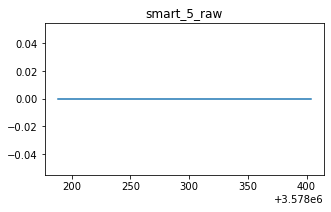

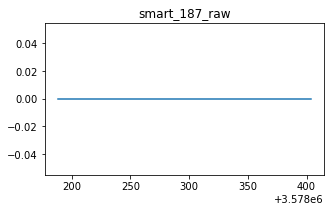

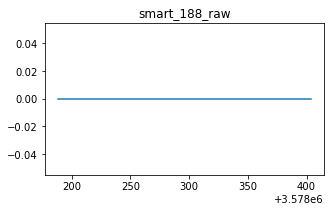

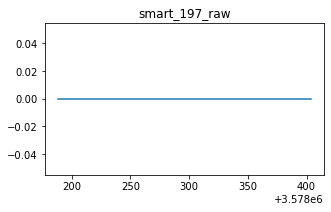

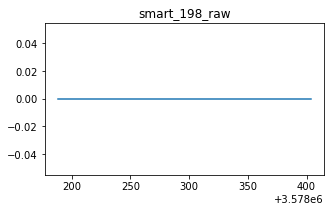

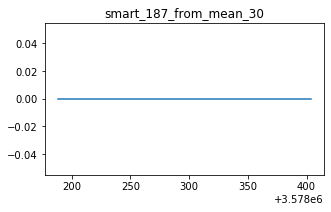

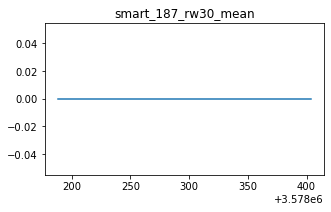

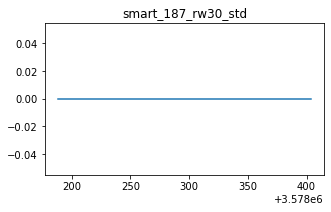

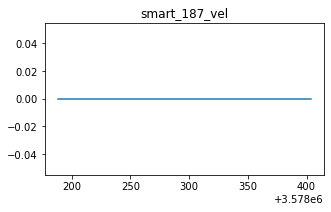

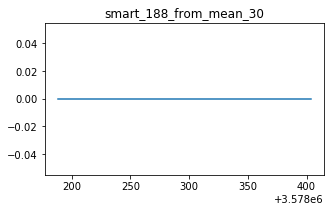

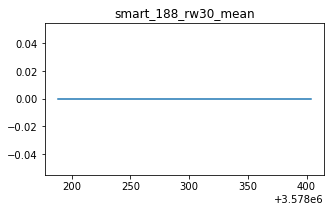

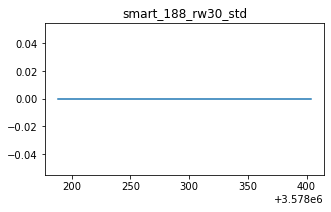

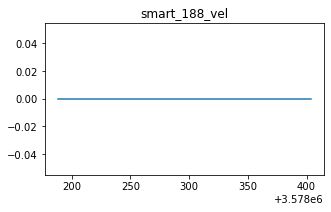

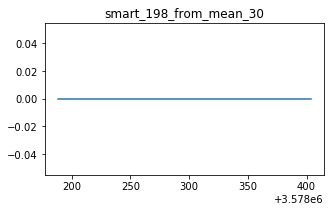

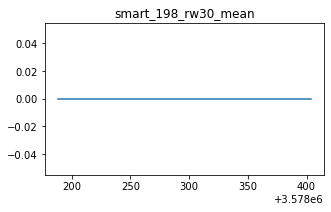

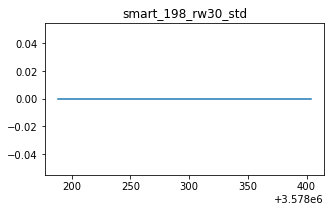

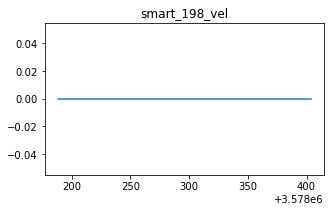

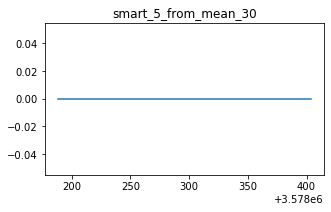

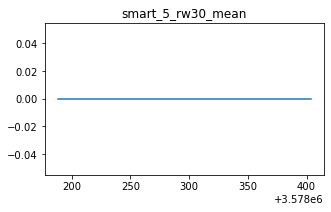

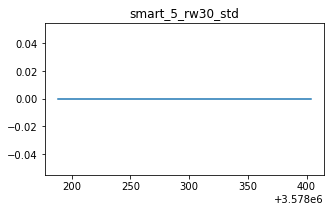

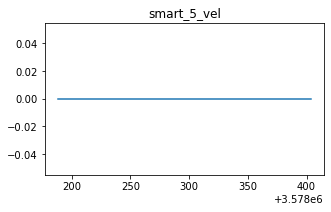

In [225]:
# False Negative
ploting_df = df[df.serial_number=='S301NL7L'].drop(['smart_9_raw','serial_number',0,'fail_next_60_days'],axis=1)
for i in range(21):
    plt.figure(figsize = (5,70))
    plt.subplot(21,1,i+1)
    plt.plot(ploting_df[ploting_df.columns[i]])
    plt.title(ploting_df.columns[i])

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


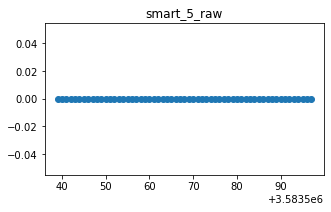

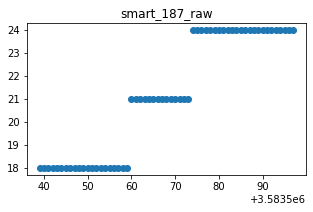

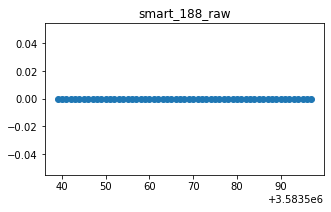

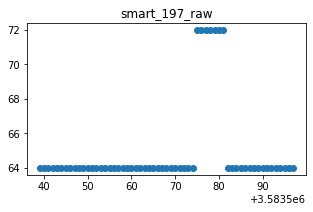

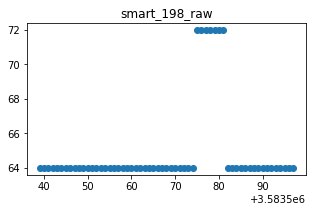

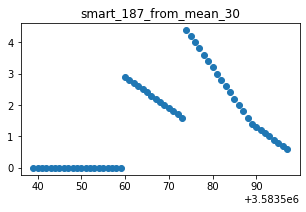

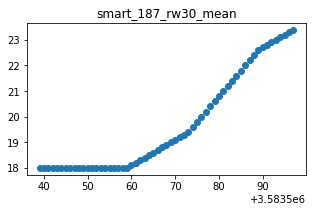

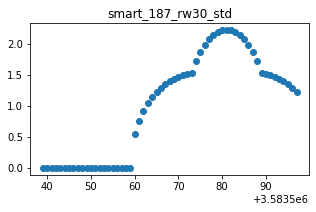

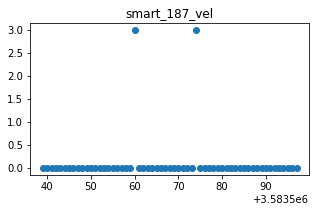

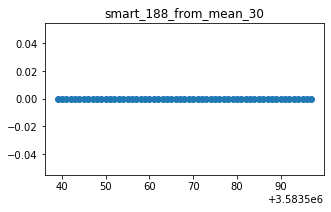

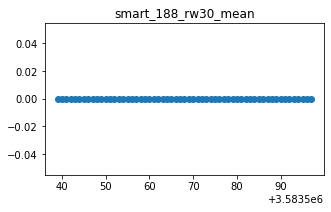

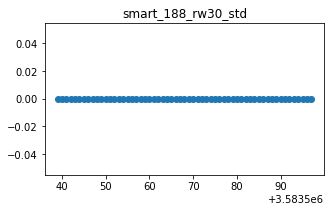

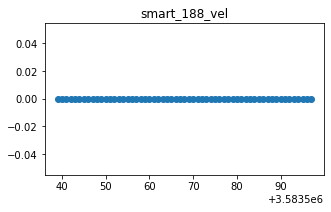

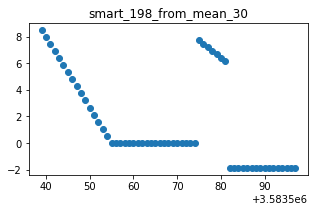

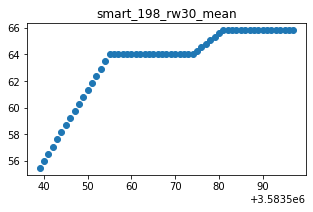

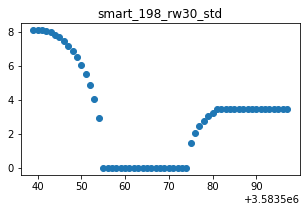

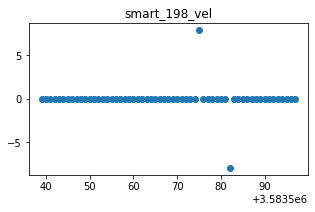

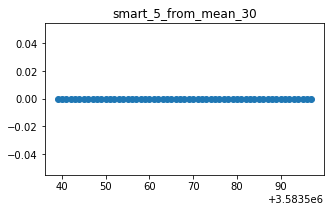

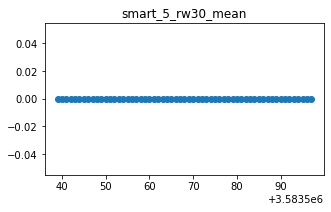

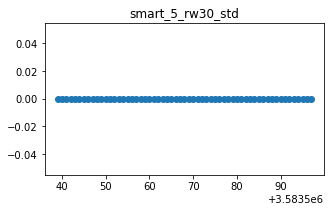

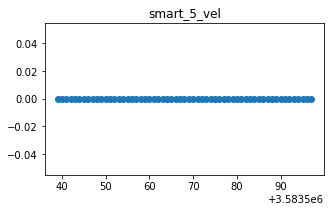

In [226]:
# True positive S300ZRP2 S301NXNV Z304JDDH
ploting_df = df[df.serial_number=='Z302SZLQ'].drop(['smart_9_raw','serial_number',0,'fail_next_60_days'],axis=1)
for i in range(21):
    plt.figure(figsize = (5,70))
    plt.subplot(21,1,i+1)
    plt.plot(ploting_df[ploting_df.columns[i]],'o')
    plt.title(ploting_df.columns[i])

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


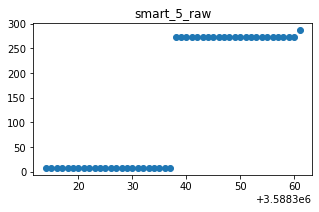

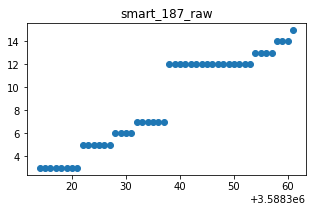

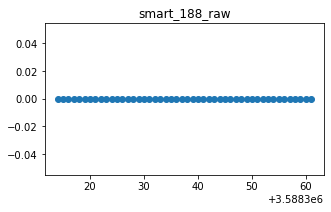

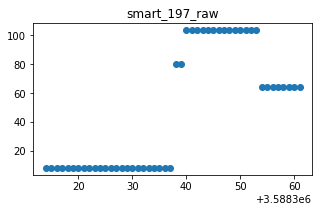

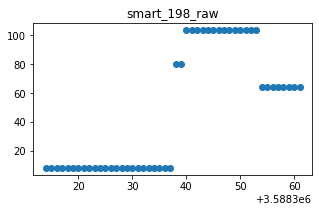

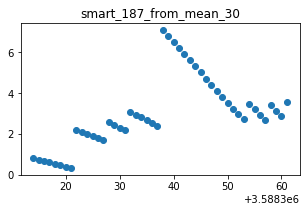

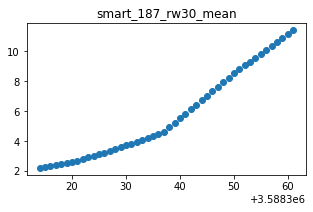

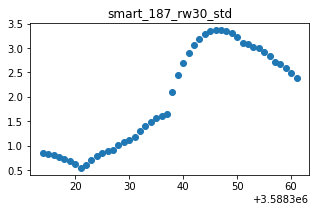

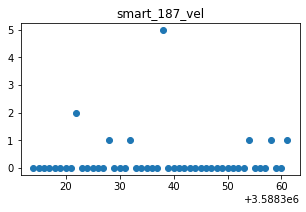

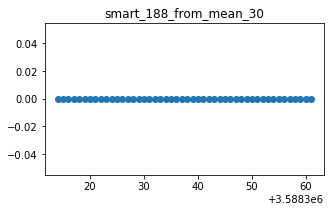

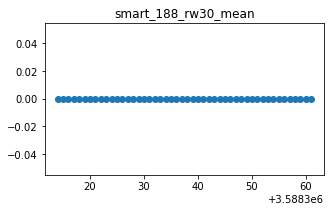

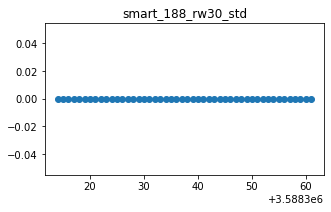

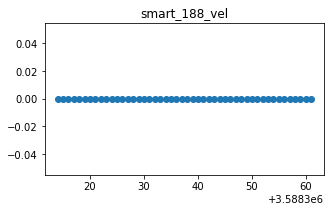

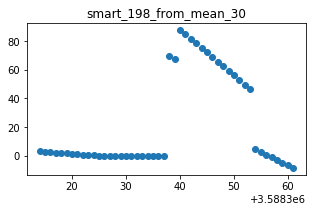

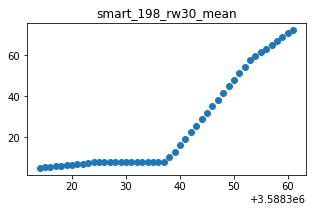

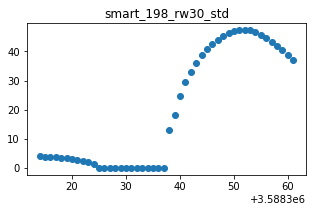

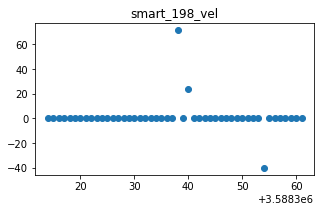

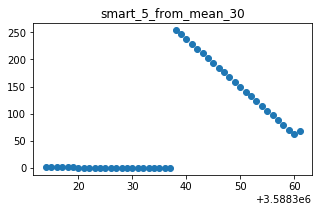

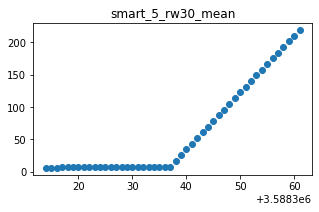

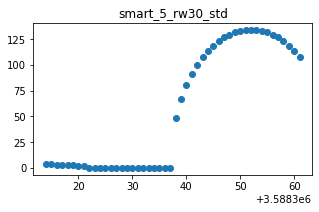

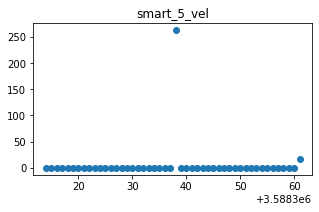

In [223]:
ploting_df = df[df.serial_number=='Z304JDDH'].drop(['smart_9_raw','serial_number',0,'fail_next_60_days'],axis=1)
for i in range(21):
    plt.figure(figsize = (5,70))
    plt.subplot(21,1,i+1)
    plt.plot(ploting_df[ploting_df.columns[i]],'o')
    plt.title(ploting_df.columns[i])

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


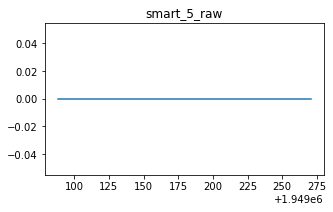

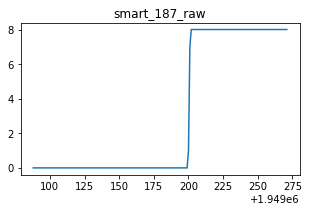

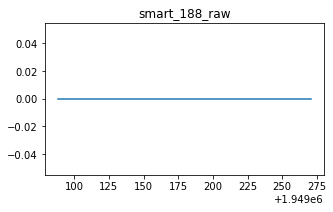

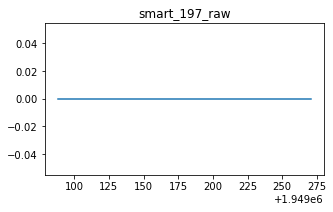

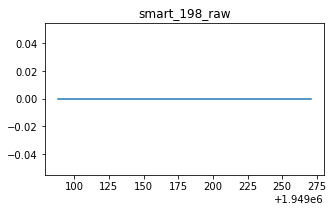

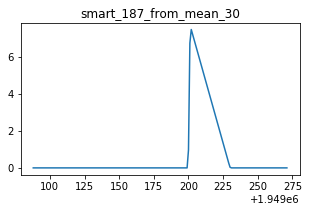

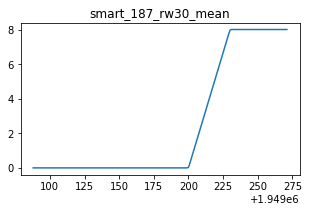

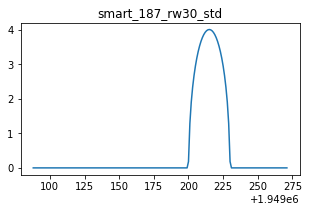

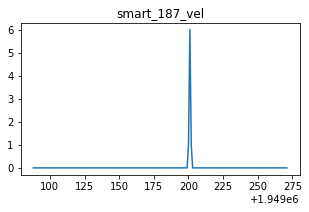

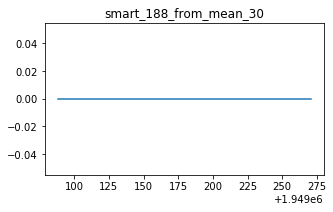

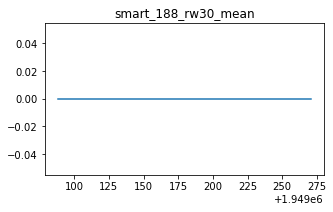

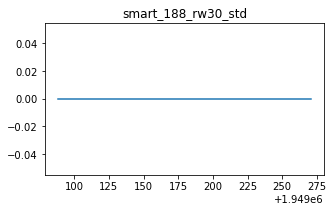

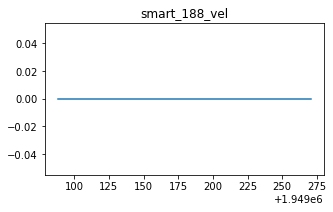

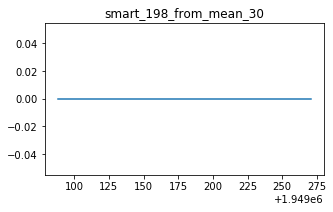

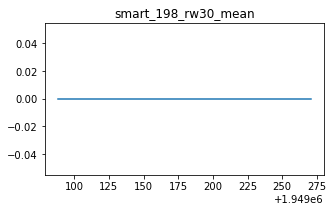

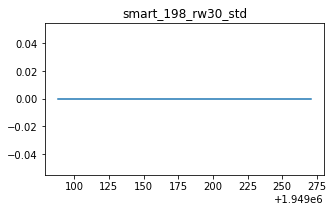

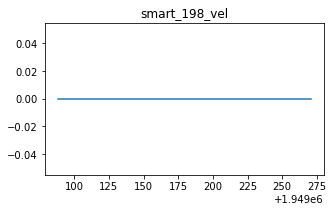

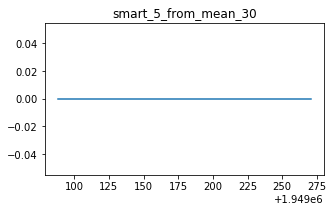

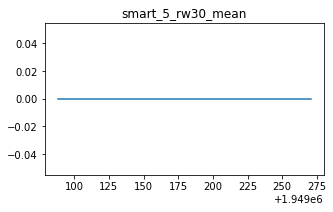

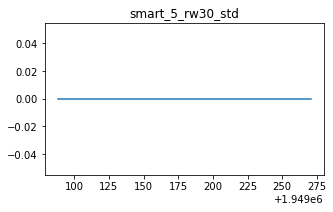

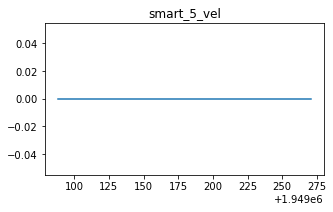

In [231]:
# False Positive 
ploting_df = df[df.serial_number=='Z304JS04'].drop(['smart_9_raw','serial_number',0,'fail_next_60_days'],axis=1)
for i in range(21):
    plt.figure(figsize = (5,70))
    plt.subplot(21,1,i+1)
    plt.plot(ploting_df[ploting_df.columns[i]])
    plt.title(ploting_df.columns[i])

In [249]:
df[df.serial_number=='Z305D63C']

,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,...,smart_198_from_mean_30,smart_198_rw30_mean,smart_198_rw30_std,smart_198_vel,smart_5_from_mean_30,smart_5_rw30_mean,smart_5_rw30_std,smart_5_vel,fail_next_60_days,0
2974116,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,27397.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
2974117,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,27421.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
2974118,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,27444.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
2974119,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,27468.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
2974120,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,27492.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974295,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,31691.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,True
2974296,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,31715.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,True
2974297,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,31739.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,True
2974298,Z305D63C,0.0,6.0,1.0,40.0,40.0,0.0,6.0,31762.0,0.0,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0,True


In [250]:
x = df[df.serial_number=='Z304JSFB'].tail( 75)

In [251]:
x.columns

Index([         'serial_number',            'smart_5_raw',
                'smart_187_raw',          'smart_188_raw',
                'smart_197_raw',          'smart_198_raw',
       'smart_187_from_mean_30',    'smart_187_rw30_mean',
                  'smart_9_raw',     'smart_187_rw30_std',
                'smart_187_vel', 'smart_188_from_mean_30',
          'smart_188_rw30_mean',     'smart_188_rw30_std',
                'smart_188_vel', 'smart_198_from_mean_30',
          'smart_198_rw30_mean',     'smart_198_rw30_std',
                'smart_198_vel',   'smart_5_from_mean_30',
            'smart_5_rw30_mean',       'smart_5_rw30_std',
                  'smart_5_vel',      'fail_next_60_days',
                              0],
      dtype='object')

In [252]:
x[['smart_187_from_mean_30',    'smart_187_rw30_mean',
                  'smart_9_raw',     'smart_187_rw30_std',
                'smart_187_vel', 'smart_188_from_mean_30',
          'smart_188_rw30_mean',     'smart_188_rw30_std',
                'smart_188_vel', 'smart_198_from_mean_30','fail_next_60_days',
                              0]].head(50)

,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,smart_187_vel,smart_188_from_mean_30,smart_188_rw30_mean,smart_188_rw30_std,smart_188_vel,smart_198_from_mean_30,fail_next_60_days,0
1949933,0.0,1.0,31662.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949934,0.0,1.0,31686.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949935,0.0,1.0,31709.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949936,0.0,1.0,31721.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949937,0.0,1.0,31745.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949938,0.0,1.0,31769.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949939,0.0,1.0,31793.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949940,0.0,1.0,31817.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949941,0.0,1.0,31840.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False
1949942,0.0,1.0,31864.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,False


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


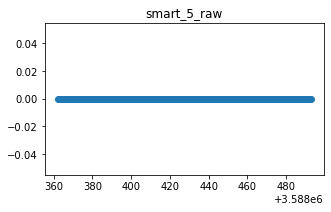

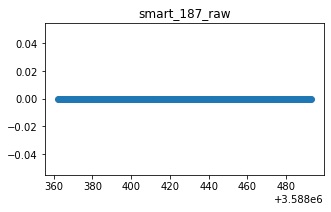

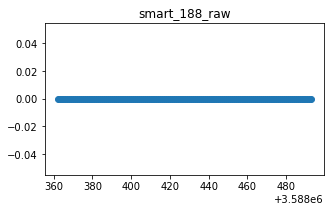

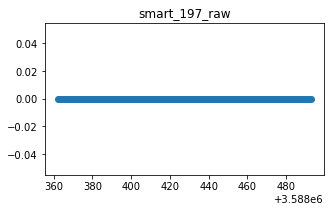

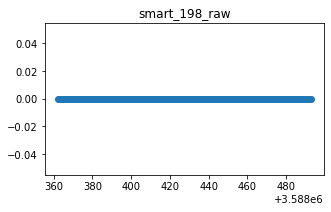

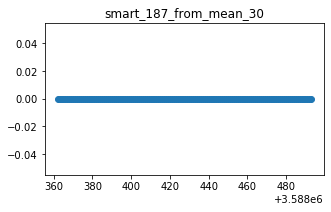

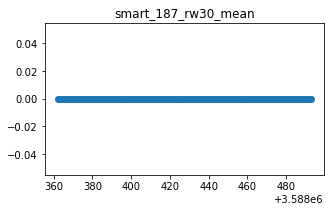

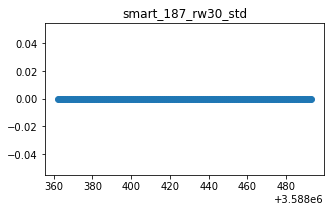

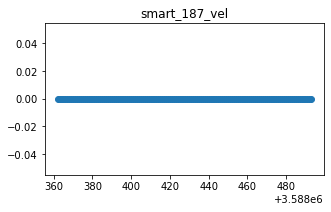

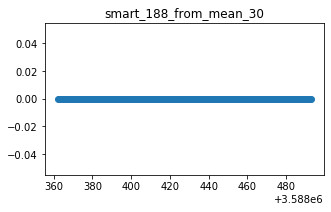

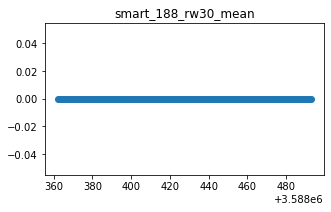

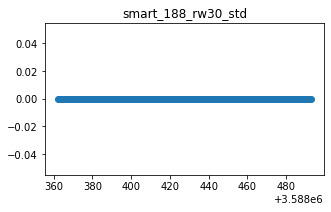

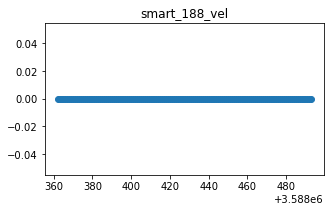

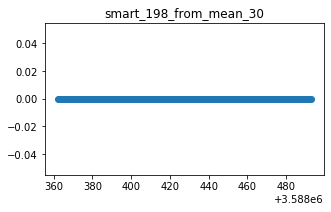

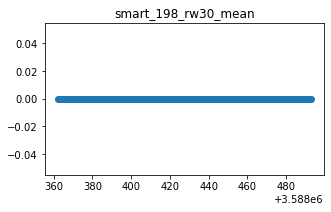

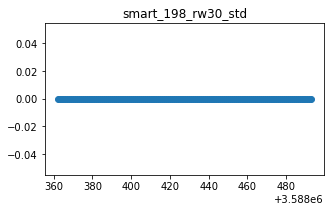

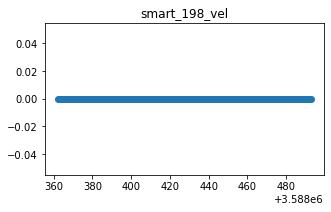

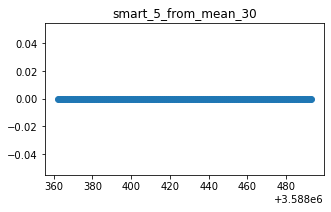

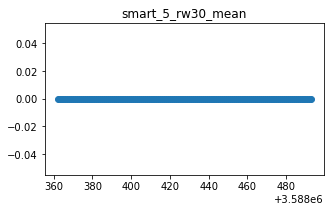

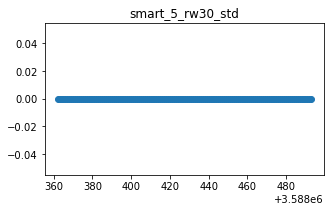

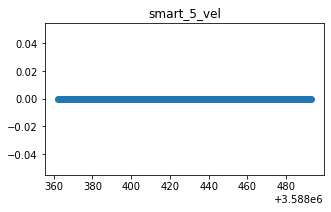

In [229]:
# False neg 
ploting_df = df[df.serial_number=='Z304JDL3'].drop(['smart_9_raw','serial_number',0,'fail_next_60_days'],axis=1)
for i in range(21):
    plt.figure(figsize = (5,70))
    plt.subplot(21,1,i+1)
    plt.plot(ploting_df[ploting_df.columns[i]],'o')
    plt.title(ploting_df.columns[i])

In [230]:
df[df.serial_number=='Z304JDL3']

,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,...,smart_198_from_mean_30,smart_198_rw30_mean,smart_198_rw30_std,smart_198_vel,smart_5_from_mean_30,smart_5_rw30_mean,smart_5_rw30_std,smart_5_vel,fail_next_60_days,0
3588362,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29070.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
3588363,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29093.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
3588364,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29117.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
3588365,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29141.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
3588366,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29164.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588489,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32113.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
3588490,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32137.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
3588491,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32161.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False
3588492,Z304JDL3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32184.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,False


In [228]:
df[df.serial_number=='Z304JD9J'].tail(30)

,serial_number,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw,smart_187_from_mean_30,smart_187_rw30_mean,smart_9_raw,smart_187_rw30_std,...,smart_198_from_mean_30,smart_198_rw30_mean,smart_198_rw30_std,smart_198_vel,smart_5_from_mean_30,smart_5_rw30_mean,smart_5_rw30_std,smart_5_vel,fail_next_60_days,0
3588284,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30471.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588285,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30495.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588286,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30519.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588287,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30543.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588288,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30567.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588289,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30591.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588290,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30615.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588291,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30638.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588292,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30662.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
3588293,Z304JD9J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30686.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1,False
